<a href="https://colab.research.google.com/github/shrestharushika/Medicine-Recommender-System/blob/master/project_dl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.proportion import proportions_chisquare
from scipy.stats import chisquare
import pickle
from bs4 import BeautifulSoup
from collections import defaultdict
import requests
from statsmodels.stats.multitest import fdrcorrection_twostage
%matplotlib inline

from keras.layers import LSTM, SpatialDropout1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D,MaxPooling2D

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drugs_train = pd.read_csv('/content/drive/My Drive/dataset/Drugs_train.csv')

drugs_train=drugs_train.dropna()
drugs_train[drugs_train['condition'].str.contains("pain",case=False)]

In [ ]:
drugs_train=drugs_train.dropna() drugs_train[drugs_train['condition'].str.contains("pain",case=False)]

,index,drugName,condition,review,rating,date,usefulCount
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192
17,219869,Amitriptyline,ibromyalgia,"""I&#039;ve been taking amitriptyline since Jan...",9,"March 15, 2017",39
21,231466,Trazodone,Insomnia,"""I have insomnia, it&#039;s horrible. My story...",10,"April 3, 2016",43
27,78563,Daytrana,ADHD,"""Hi all, My son who is 12 was diagnosed when h...",10,"January 12, 2017",11
28,132258,Ativan,Panic Disorde,"""Honestly, I have been taking ativan for 2 yea...",6,"June 1, 2015",47
...,...,...,...,...,...,...,...
161277,18421,Zolpidem,Insomnia,"""I started taking this medication 10 years ago...",10,"November 16, 2008",103
161284,121154,Venlafaxine,Panic Disorde,"""Had panic attacks and social anxiety starting...",9,"November 10, 2016",25
161287,132177,Ativan,Anxiety,"""I was super against taking medication. I&#039...",9,"August 16, 2016",61
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,"May 31, 2015",125


In [4]:
drugs_train.shape

(161297, 7)

In [5]:
drugs_test= pd.read_csv('/content/drive/My Drive/dataset/drugsComTest_raw.tsv',sep='\t',index_col=0)

In [ ]:
drugs_test.shape

In [ ]:
drugs_train.head()

,index,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37


In [ ]:
drugs_train.tail()

,index,drugName,condition,review,rating,date,usefulCount
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,"May 31, 2015",125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,"November 1, 2011",34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,"March 15, 2014",35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,"September 19, 2015",79
161296,215220,Lubiprostone,"Constipation, Chronic","""I&#039;ve had chronic constipation all my adu...",9,"December 13, 2014",116


In [ ]:

drugs_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   index        161297 non-null  int64 
 1   drugName     161297 non-null  object
 2   condition    160398 non-null  object
 3   review       161297 non-null  object
 4   rating       161297 non-null  int64 
 5   date         161297 non-null  object
 6   usefulCount  161297 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [ ]:
drugs_train.describe()

,index,rating,usefulCount
count,161297.000000,161297.000000,161297.000000
mean,115923.585305,6.994377,28.004755
std,67004.445170,3.272329,36.403742
min,2.000000,1.000000,0.000000
25%,58063.000000,5.000000,6.000000
50%,115744.000000,8.000000,16.000000
75%,173776.000000,10.000000,36.000000
max,232291.000000,10.000000,1291.000000


In [ ]:
#Creating Date Field
drugs_train['date'] = pd.to_datetime(drugs_train['date'])

In [ ]:
drugs_train.head()

,index,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


### **EDA**

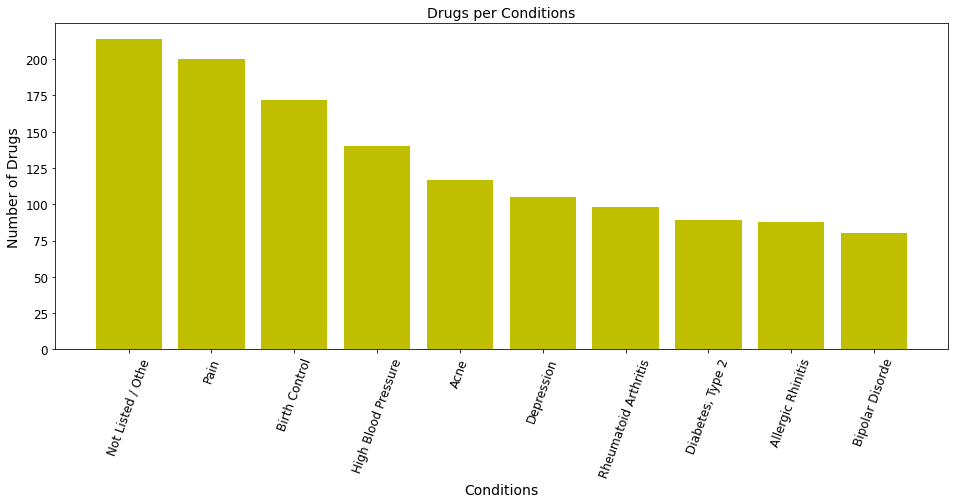

In [ ]:
# Drugs available for top conditions
df = drugs_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending = False).reset_index().head(10)
plt.rcParams['figure.figsize'] = [16, 6]
plt.bar(x=df['condition'],height = df['drugName'],color='y')
plt.xticks(rotation=90)
plt.title('Drugs per Conditions', fontsize = 14)
plt.xlabel('Conditions', fontsize = 14)
plt.ylabel('Number of Drugs', fontsize = 14)
plt.xticks(rotation=70)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

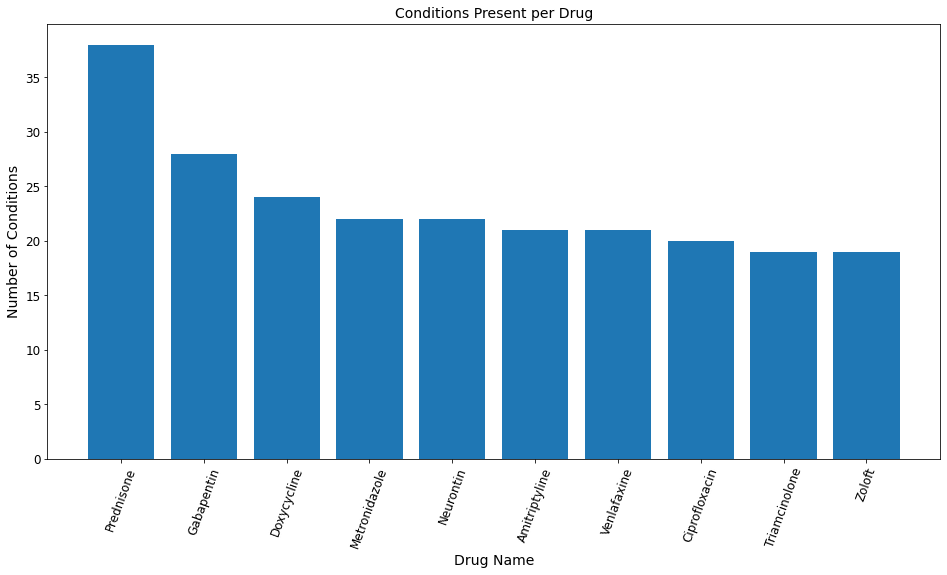

In [ ]:
# Number of conditions present per drug
df = drugs_train.groupby(['drugName'])['condition'].nunique().sort_values(ascending = False).reset_index().head(10)
plt.rcParams['figure.figsize'] = [16, 8]
plt.bar(x=df['drugName'],height = df['condition'])

plt.title('Conditions Present per Drug', fontsize = 14)
plt.xlabel('Drug Name', fontsize = 14)
plt.ylabel('Number of Conditions', fontsize = 14)
plt.xticks(rotation=70)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

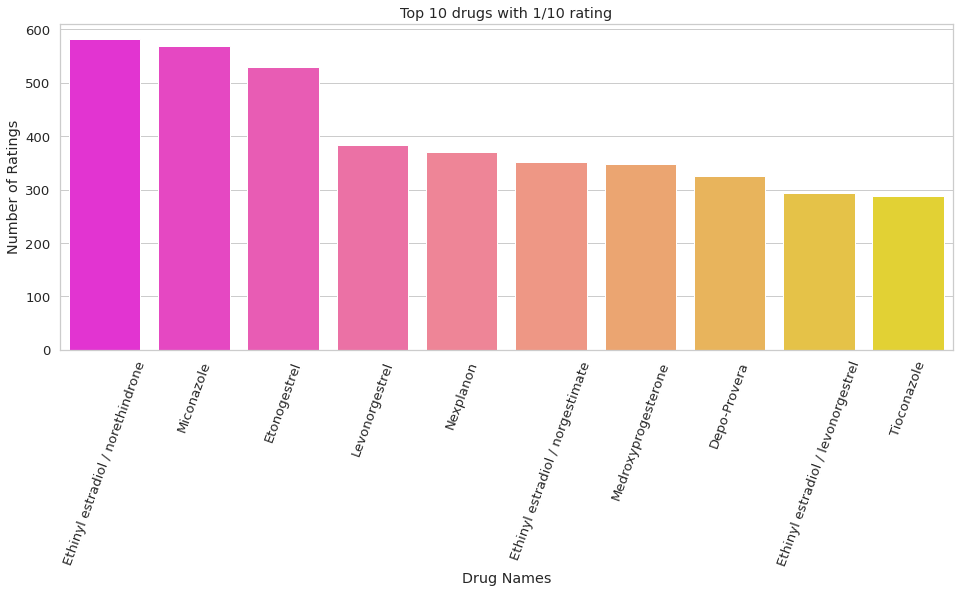

In [ ]:
# Top drugs with ratig 1/10
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [16, 6]

rating = dict(drugs_train.loc[drugs_train.rating == 1, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:10], y = drug_rating[0:10], palette = 'spring')

sns_rating.set(title = 'Top 10 drugs with 1/10 rating', ylabel = 'Number of Ratings', xlabel = "Drug Names")

plt.setp(sns_rating.get_xticklabels(), rotation=70);

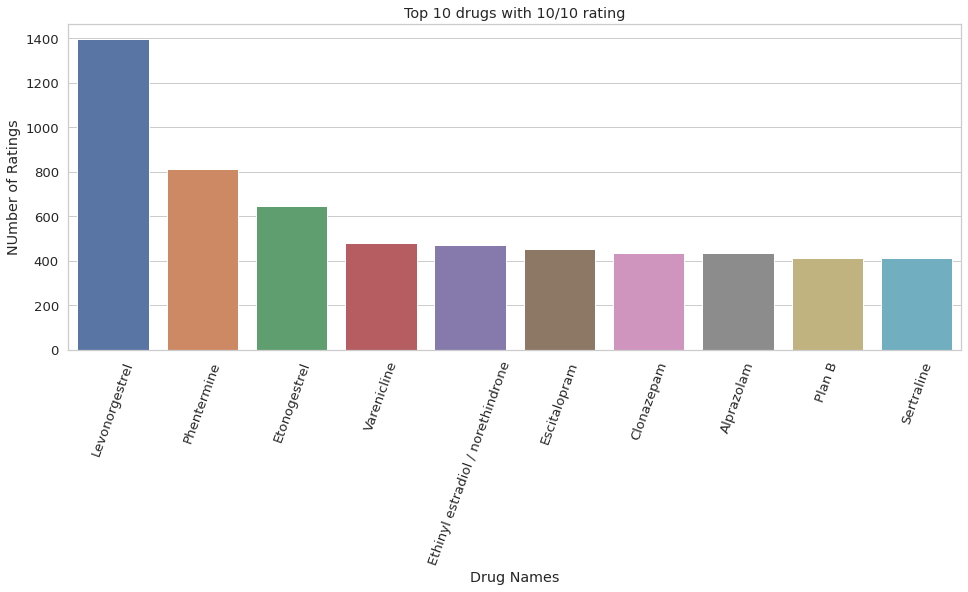

In [ ]:
# Top10 drugs with the rating 10/10

sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [16, 6]

rating = dict(drugs_train.loc[drugs_train.rating == 10, "drugName"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:10], y = drug_rating[0:10])

sns_rating.set(title = 'Top 10 drugs with 10/10 rating', ylabel = 'NUmber of Ratings', xlabel = "Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=70);

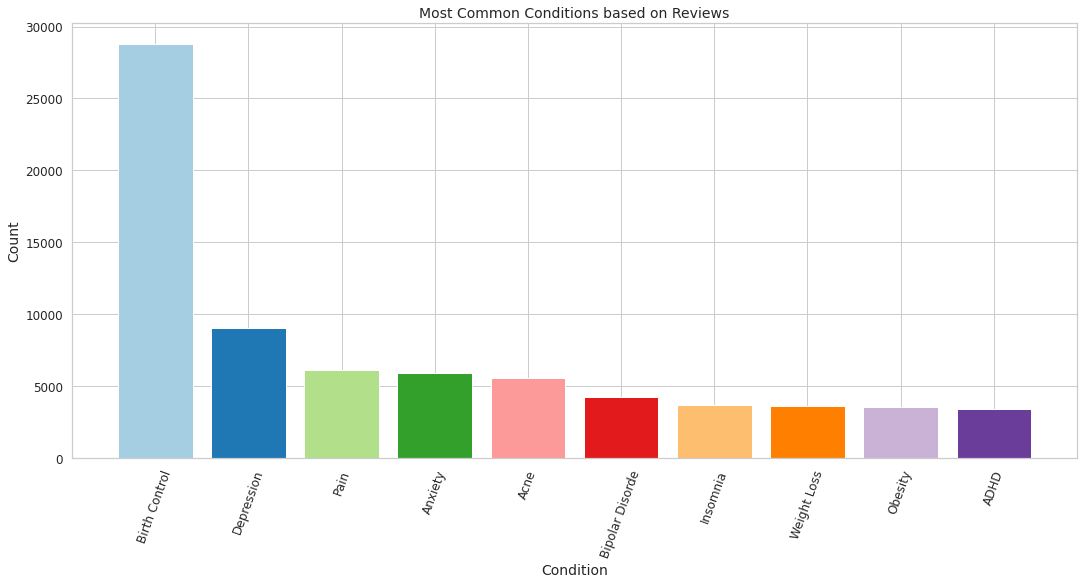

In [ ]:
# Top Conditions based on Reviews
df = drugs_train['condition'].value_counts().head(10).reset_index()
df.columns = ['condition','count']
plt.rcParams['figure.figsize'] = [18, 8]
plt.bar(x=df['condition'],height = df['count'], color=plt.cm.Paired(np.arange(len(df))))
plt.xticks(rotation=70)
plt.title('Most Common Conditions based on Reviews', fontsize = 14)
plt.xlabel('Condition', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
# Extract Year and Month

drugs_train['year'] = drugs_train['date'].dt.year
drugs_train['month'] = drugs_train['date'].dt.month

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


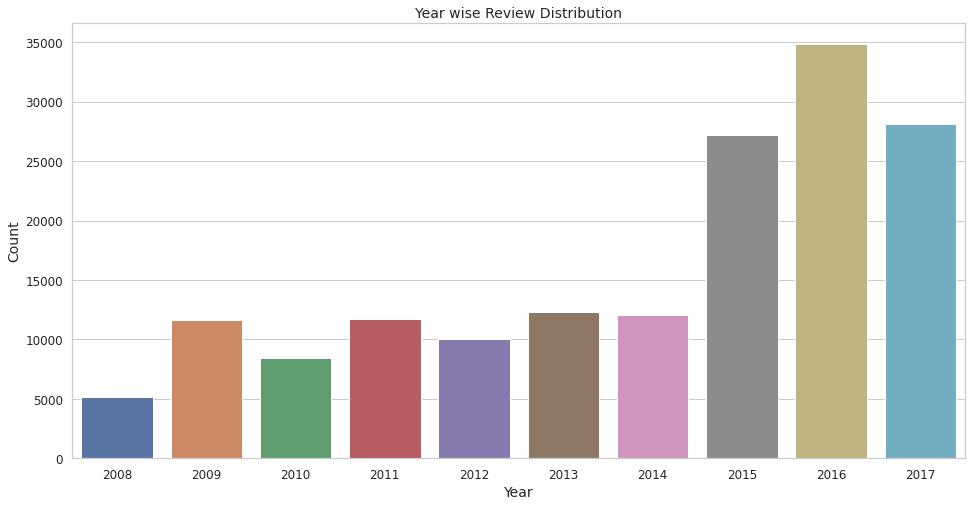

In [ ]:
# Distribution of reviews in each year]

plt.rcParams['figure.figsize'] = (16, 8)
sns.countplot(drugs_train['year'])
plt.title('Year wise Review Distribution', fontsize = 14)
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Count', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
drugs_train["Word Count"] = drugs_train['review'].str.split().str.len()

In [ ]:
drugs_train['Word Count'].describe()

count    161297.000000
mean         84.699802
std          45.044833
min           1.000000
25%          48.000000
50%          84.000000
75%         126.000000
max        1894.000000
Name: Word Count, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


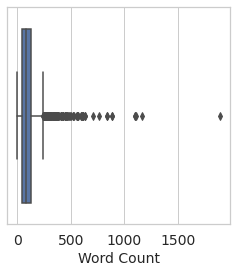

In [ ]:
plt.figure(figsize=(4,4))
sns.boxplot(drugs_train['Word Count'])
plt.xlabel('Word Count', fontsize = 14)
plt.xticks(fontsize=14)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


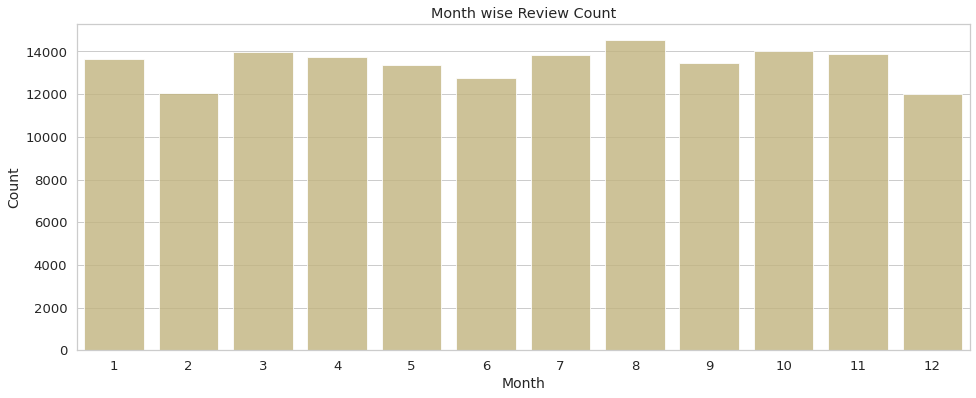

In [ ]:
# Month Wise Review Count

cnt_srs = drugs_train['date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(16,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='y')
plt.xticks(rotation='vertical')
plt.xlabel('Month', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title("Month wise Review Count")
plt.xticks(rotation=360)
plt.show()

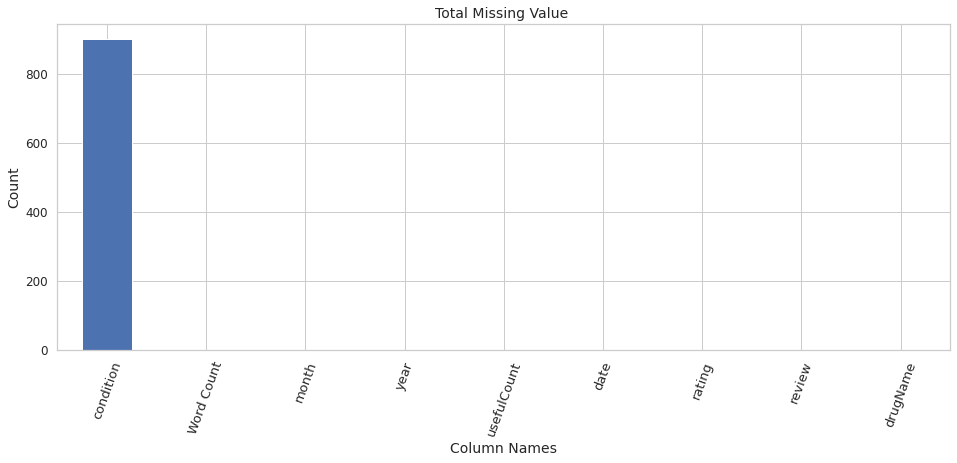

In [ ]:
# Missing Values

percent = (drugs_train.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (16,6), fontsize = 14, color='b')
plt.xlabel("Column Names", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.title("Total Missing Value ", fontsize = 14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.xticks(rotation=70)
plt.show()

In [ ]:
drugs_train.isnull().sum()

index            0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [ ]:
from wordcloud import WordCloud
from collections import Counter

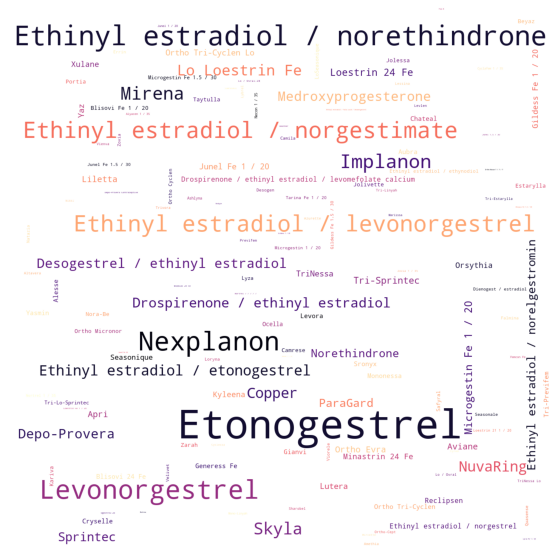

In [ ]:
condition=Counter(drugs_train['condition'])
drugs=drugs_train[drugs_train['condition']=="Birth Control"]['drugName']

dictionary=Counter(drugs)
wordcloud=WordCloud(width=1280,height=1280,random_state=42,colormap='magma',background_color='white').generate_from_frequencies(dictionary)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

# Users found Etonogestrel and Levonogestrel useful

In [ ]:
drugs_train['condition'].isnull().sum()

899

In [6]:
# Load dataset.
train_df =  pd.read_csv('/content/drive/My Drive/dataset/Drugs_train.csv')
test_df = pd.read_csv('/content/drive/My Drive/dataset/drugsComTest_raw.tsv',sep='\t',index_col=0)

In [7]:
train_df.shape

(161297, 7)

In [8]:
test_df.shape

(53766, 6)

In [9]:
train_df = train_df.dropna(axis = 0)

train_df.shape

(160398, 7)

In [10]:
test_df.isnull().sum()

drugName         0
condition      295
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [11]:
test_df.shape

(53766, 6)

In [12]:
test_df=test_df.dropna(axis=0)

test_df.shape

(53471, 6)

In [18]:
import pandas as pd
import numpy as np
import re, string, unicodedata

!pip install inflect
import inflect
from string import punctuation
from tqdm import tqdm   # to add progress bars

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import nltk

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

from keras.models import Model, Sequential
from keras.models import load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop, SGD
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer


from bs4 import BeautifulSoup
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

%matplotlib inline

In [19]:
#SENTIMENT ANALYSIS

In [20]:
train_df['review'].head(10)

0    "It has no side effect, I take it in combinati...
1    "My son is halfway through his fourth week of ...
2    "I used to take another oral contraceptive, wh...
3    "This is my first time using any form of birth...
4    "Suboxone has completely turned my life around...
5    "2nd day on 5mg started to work with rock hard...
6    "He pulled out, but he cummed a bit in me. I t...
7    "Abilify changed my life. There is hope. I was...
8    " I Ve had  nothing but problems with the Kepp...
9    "I had been on the pill for many years. When m...
Name: review, dtype: object

In [21]:
train_df.shape

(160398, 7)

In [22]:
def rank_bin(array):
  y_rank = []
  for i in array:
    if i <= 4: # Negative rating
      y_rank.append('Negative')
    elif i >= 7: # Positive Rating 
      y_rank.append('Positive')
    else:   # neutral 
      y_rank.append('Neutral')
  return y_rank



In [23]:
# Assigning test and train data their classes
train_df['classes_to_predict'] = rank_bin(train_df['rating'])
test_df['classes_to_predict'] = rank_bin(test_df['rating'])

# Making a variable to contain the class labels
classes_to_predict = ['Positive','Negative','Neutral']
print(train_df['classes_to_predict'].value_counts())
print(test_df['classes_to_predict'].value_counts()) 

Positive    106310
Negative     39828
Neutral      14260
Name: classes_to_predict, dtype: int64
Positive    35250
Negative    13428
Neutral      4793
Name: classes_to_predict, dtype: int64


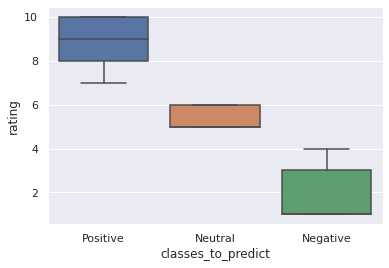

In [24]:
# Displaying the coverage for each group by its rating.
sns.boxplot(x='classes_to_predict', y="rating", data=train_df)
plt.show()

In [25]:
train_df.head()

,index,drugName,condition,review,rating,date,usefulCount,classes_to_predict
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,"May 20, 2012",27,Positive
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,"April 27, 2010",192,Positive
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,"December 14, 2009",17,Neutral
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,"November 3, 2015",10,Positive
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,"November 27, 2016",37,Positive


In [26]:
nltk.download('stopwords')

drug_stopwords = pd.read_csv('/content/drive/My Drive/dataset/drugname_stopwords.csv')  # extending stopwords

print(drug_stopwords[0:5])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
   Unnamed: 0  drugs_stopwords
0           0    acetaminophen
1           1  pseudoephedrine
2           2    phenylephrine
3           3        estradiol
4           4          codeine


In [27]:
# Preprocessing

# removal of special characters
remove_special_char = re.compile('r[^a-z\d]',re.IGNORECASE)

# regex to replace all numerics
replace_numerics = re.compile(r'\d+',re.IGNORECASE)

# Loading NLTK stop words
stop_words = nltk.corpus.stopwords.words('english')
print ("NLTK stopword list length: ",len(stop_words),'words')

# Adding custom drug stopwords
stop_words.extend(drug_stopwords)

def remove_punctuation(words):
    """ used to remove punctuation"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """used to replace all interger occurrences in list"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """used to remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stop_words:
            new_words.append(word)
    return new_words

def normalize(words):
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    return words


NLTK stopword list length:  179 words


In [28]:
# Defining Text-PreProcessing function
def preprocess_text(text, remove_stopwords = True, perform_stemming = True):
    #first clean text then go to lowercase and split.
    text = text.replace(r"http\S+", "")
    text = text.replace(r"http", "")
    text = text.replace(r"(\d)", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"@", "at")
    text = remove_special_char.sub('', text)
    text = replace_numerics.sub('n', text)
    text = text.replace( r"(\\r)|(\\n)|(\\t)|(\\f)|(\.)|(\;)|(\:)|(\!)|(\')|(\?)|(\,)|(\")|(\()|(\))|(\[)|(\])|(&#039;)|(\d\s)|(\d)|(\/)","")
    text = text.replace( r"(\-)|(\\)|(\s{2,})"," ")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"(&#n;)", "")
    
    # per/word processing
    textlist = text.lower().split()
    textlist = normalize(textlist)
    text = ' '.join(textlist) 

    # stemming  
    if(perform_stemming):
        text = text.split()
        stemmer = SnowballStemmer('english')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = ' '.join(stemmed_words)
        
    return text


In [29]:
# Clean text
raw_train_reviews = train_df['review'].fillna('NA').values
raw_test_reviews = test_df['review'].fillna('NA').values

# Define y for Training/Validation 
y = pd.get_dummies(train_df['classes_to_predict']).values

# Define y for Tests
y_test_predicted = pd.get_dummies(test_df['classes_to_predict']).values



In [30]:
# Process reviews for Training (X)
processed_train_reviews = []
for review in tqdm(raw_train_reviews):
    processed_train_reviews.append(preprocess_text(review))

# Process reviews
processed_test_reviews = []    
for review in tqdm(raw_test_reviews):
    processed_test_reviews.append(preprocess_text(review))

100%|██████████| 53471/53471 [00:57<00:00, 926.90it/s]


In [31]:
#printing the processed text after preprocessing
print (processed_train_reviews[0:5])
print (processed_test_reviews[0:5])
print (y[0:5])
print (y_test_predicted[0:5])

['side effect take combin bystol n mg fish oil', 'son halfway fourth week intuniv becam concern began last week start take highest dose fotwo day could hard get bed cranki slept fonear n hour drive home school vacat unusu fohim call doctoon monday morn said stick day see school get morn last two day problem free much agreeabl eve less emot good thing less cranki rememb thing overal behavioi bett tri mani differ medic fathi effect', 'use take anotheor contracept n pill cycl happi light period max n day othesid effect contain hormon gestoden avail us switch lybrel ingredi simila othepil end start lybrel immedi first day period instruct said period last fotwo week take second pack two week third pack thing got even wors third period last fotwo week itn end third week still daili brown discharg posit side didnnt othesid effect idea period free tempt ala', 'first time use form birth control inm glad went patch fon month first decreas libido subsid downsid made period longenn day exact use p

In [32]:
# saving the new processed text in a csv file

np.savetxt("y_trainn.csv", y, delimiter=",", fmt='%s')
np.savetxt("y_testt.csv", y_test_predicted, delimiter=",", fmt='%s')
np.savetxt("processed_train_reviews.csv", processed_train_reviews, delimiter=",", fmt='%s')
np.savetxt("processed_test_reviews.csv", processed_test_reviews, delimiter=",", fmt='%s')

In [33]:
 #reload to check
 
processed_train_reviews = [line.strip() for line in open("processed_train_reviews.csv", 'r')]
processed_test_reviews = [line.strip() for line in open("processed_test_reviews.csv", 'r')]

y = np.loadtxt(open("y_trainn.csv", "r"), delimiter=",").astype("int")
y_test_predicted = np.loadtxt(open("y_testt.csv", "rb"), delimiter=",").astype("int")


In [ ]:
print (len(processed_train_reviews))
print (len(y))
print (len(processed_test_reviews))
print (len(y_test_predicted))

160398
160398
53471
53471


In [34]:
train_df_ii = pd.DataFrame(y)
train_df_ii[3] = processed_train_reviews


print(train_df_ii[3].str.split().str.len().mean())
print(train_df_ii[3].str.split().str.len().max())
train_df_ii["strlen"] = train_df_ii[3].str.split().str.len()



43.537949350989415
969


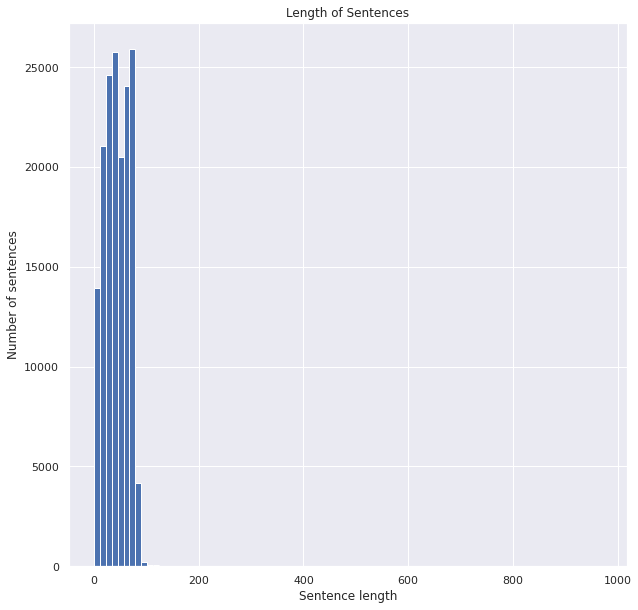

In [35]:
fig = plt.figure(figsize=(10, 10)) 
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.title('Length of Sentences')
plt.hist(train_df_ii["strlen"], bins=86)
plt.show()

In [36]:
r1 = train_df_ii.loc[train_df_ii["strlen"] >= 1000].strlen.count()
r2 = train_df_ii.loc[train_df_ii["strlen"] >= 750].strlen.count()
r3 = train_df_ii.loc[train_df_ii["strlen"] >= 250].strlen.count()
r4 = train_df_ii.loc[train_df_ii["strlen"] >= 180].strlen.count()
r5 = train_df_ii.loc[train_df_ii["strlen"] >= 100].strlen.count()
r6 = train_df_ii.loc[train_df_ii["strlen"] < 100].strlen.count()
print (" Number of Reviews by Length \n %s >1000 words \n %s >750 words \n %s >250 words \n %s >180 words \n %s >100 words \n %s <100 words\n" % (r1,r2,r3,r4,r5,r6))


 Number of Reviews by Length 
 0 >1000 words 
 1 >750 words 
 30 >250 words 
 70 >180 words 
 270 >100 words 
 160128 <100 words



In [37]:
maximum_seq_len= 100 
max_nb_words_ = 3000
embedding_dim = 160

In [38]:
# Dropping long reviews as most of the reviews are having less than 100 words
train_df_ii = train_df_ii.loc[train_df_ii["strlen"] <= maximum_seq_len]

print("New word count mean:", train_df_ii[3].str.split().str.len().mean())
print("New word count max:",train_df_ii[3].str.split().str.len().max())


New word count mean: 43.33098529981141
New word count max: 100


In [39]:
post_processed_train_reviews = train_df_ii[3].tolist()
post_processed_y = train_df_ii[[0, 1, 2]].values

In [40]:
# Tokenize the data
#Tokenization is essentially splitting a phrase, sentence, paragraph, or an entire text document into smaller units, such as individual words or terms. 
#Each of these smaller units are called tokens. 
tokenizer = Tokenizer(num_words = max_nb_words_ , 
                      filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~',
                      lower=True, split=' ', char_level=False)

tokenizer.fit_on_texts(post_processed_train_reviews + processed_test_reviews)

In [41]:
# Converting to sequences

#Transforms each text in texts to a sequence of integers.
# So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary.

train_sequences = tokenizer.texts_to_sequences(post_processed_train_reviews)
test_sequences = tokenizer.texts_to_sequences(processed_test_reviews)

word_index = tokenizer.word_index


In [42]:
#  all sequences have the same length. 

train_data = pad_sequences(train_sequences, maxlen = maximum_seq_len)
final_test_data = pad_sequences(test_sequences, maxlen = maximum_seq_len)

print(train_data.shape, '<-- shape of train_data')
print(final_test_data.shape, '<-- shape of final test data ready for feeding to network.')


(160134, 100) <-- shape of train_data
(53471, 100) <-- shape of final test data ready for feeding to network.


In [43]:
train_data

array([[   0,    0,    0, ...,   77, 2767, 1268],
       [   0,    0,    0, ...,   26, 2792,    5],
       [   0,    0,    0, ...,  761,   21,  306],
       ...,
       [   0,    0,    0, ..., 1340,  187,   26],
       [   0,    0,    0, ...,  509,  798,  147],
       [   0,    0,    0, ...,   29,  325,   37]], dtype=int32)

In [44]:
post_processed_y

array([[0, 0, 1],
       [0, 0, 1],
       [0, 1, 0],
       ...,
       [1, 0, 0],
       [0, 0, 1],
       [0, 0, 1]])

In [45]:
# Train Validation Split
X_train, X_val, Y_train, Y_val = train_test_split(train_data, post_processed_y,
                                                  test_size = 0.2,  stratify= post_processed_y, 
                                                  random_state = 2020)
X_test = final_test_data
Y_test = y_test_predicted

print('Train data shape:', X_train.shape)
print('Validation data shape:', X_val.shape)

Train data shape: (128107, 100)
Validation data shape: (32027, 100)


In [ ]:
Y_train

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
Y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [ ]:
Y_val

array([[1, 0, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [1, 0, 0]])

In [46]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Decision Tree**

In [ ]:
# Fitting Decision Tree Classification to the Training set
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier(criterion = 'entropy')
classifier.fit(X_train, Y_train)

In [ ]:

# Predicting the Test set results

y_pred = classifier.predict(X_test)
y_pred

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.61      0.61      0.61     13428
           1       0.50      0.53      0.52      4793
           2       0.83      0.81      0.82     35250

   micro avg       0.74      0.74      0.74     53471
   macro avg       0.65      0.65      0.65     53471
weighted avg       0.74      0.74      0.74     53471
 samples avg       0.74      0.74      0.74     53471



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**KNN**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_train,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [ ]:
y_pred = classifier.predict(X_test)
y_pred

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]])

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.30      0.33     13428
           1       0.18      0.11      0.13      4793
           2       0.71      0.74      0.72     35250

   micro avg       0.60      0.57      0.59     53471
   macro avg       0.42      0.38      0.40     53471
weighted avg       0.58      0.57      0.57     53471
 samples avg       0.57      0.57      0.57     53471



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
X_val

array([[   0,    0,    0, ...,  419,   46,  632],
       [   0,    0,    0, ...,   37,  286,  190],
       [   0,    0,    0, ...,   42,   91,   47],
       ...,
       [   0,    0,    0, ...,  312,  536,  667],
       [   0,    0,    0, ...,  169,    2,   41],
       [   0,    0,    0, ...,    4, 1659,  631]], dtype=int32)

In [ ]:
Y_test

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [0, 0, 1]])

### **Deep Learning**

In [47]:
MAX_SEQUENCE_LENGTH= 100 
max_nb_words_ = 3000
EMBEDDING_DIM = 160


In [48]:


nb_words  = min(3000, len(word_index))
lstm_out = MAX_SEQUENCE_LENGTH

model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)

In [ ]:
model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping,model_checkpoint], verbose = 0)



In [ ]:
losses = pd.DataFrame(model.history.history)
print(losses)

       loss  accuracy  val_loss  val_accuracy
0  0.246353  0.909240  0.541445      0.840728
1  0.239776  0.911363  0.536371      0.843164
2  0.233010  0.914353  0.531101      0.845224
3  0.227930  0.916406  0.530509      0.847785
4  0.222262  0.918935  0.528432      0.845318
5  0.216256  0.920707  0.555128      0.839854
6  0.212424  0.921831  0.546095      0.846536
7  0.209717  0.923517  0.545686      0.847504
8  0.205905  0.924126  0.567148      0.848378


In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test = sc.fit_transform(X_test)

In [ ]:
# X_test=sc.inverse_transform(X_test)
final_pred=model.predict_classes(X_test)
len(final_pred)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


53471

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_test= sc.fit_transform(X_test)


In [ ]:
pd.DataFrame(final_pred)

,0
0,2
1,2
2,2
3,2
4,2
...,...
53466,2
53467,2
53468,2
53469,2


In [ ]:
test_df=test_df.iloc[:53471,:]

In [ ]:
test_df["predicted"]=sentiment

In [ ]:
from google.colab import files
# files.download("test_df.csv")
test_df.to_csv("test_df.csv")

In [ ]:
f=final_pred
f

array([2, 2, 2, ..., 2, 2, 2])

In [ ]:
sentiment=[]
for k in f:
    if k==0:
        sentiment.append("Negative")
    elif k==1:
        sentiment.append("Neutral")
    else:
        sentiment.append("positive")
        

In [ ]:
sentiment=[]
for k in f:
    if k==0:
        sentiment.append("Negative")
    elif k==1:
        sentiment.append("Neutral")
    else:
        sentiment.append("positive")
sentiment        

['positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',

In [ ]:
test_df["predicted"]=sentiment
from google.colab import files
files.download("test_df.csv")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
sentiment=[]
for k in f:
    if k==0:
        sentiment.append("Negative")
    elif k==1:
        sentiment.append("Neutral")
    else:
        sentiment.append("positive")
test_df["predicted"]=sentiment
from google.colab import files
files.download("final.csv")
        

In [ ]:
print(model.metrics_names)
print(model.evaluate(X_test,Y_test,verbose=0))

['loss', 'accuracy']
[0.5173752903938293, 0.8333147168159485]


In [ ]:
final_pred

array([[4.9187583e-05, 1.5563238e-04, 9.9979514e-01],
       [3.1086098e-04, 5.5195885e-03, 9.9416959e-01],
       [4.4941986e-03, 3.8494859e-03, 9.9165630e-01],
       ...,
       [7.1700327e-03, 4.7496832e-03, 9.8808026e-01],
       [9.9290633e-01, 4.2352830e-03, 2.8583498e-03],
       [2.7539888e-01, 3.5495356e-02, 6.8910581e-01]], dtype=float32)

In [ ]:
 print ("{:f}".format(float("9.8808026e-01")))

0.988080


In [ ]:
#Summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 128)          61568     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 128)           0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 303       
Total params: 633,471
Trainable params: 633,471
Non-trainable params: 0
________________________________________________

In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)


# Run  Model


In [50]:
from keras.layers import GRU
m3 = Sequential()
m3.add(Embedding(nb_words,EMBEDDING_DIM, input_length = MAX_SEQUENCE_LENGTH))
m3.add(GRU(MAX_SEQUENCE_LENGTH,dropout = 0.2, recurrent_dropout = 0.2, return_sequences = True))
m3.add(GRU(MAX_SEQUENCE_LENGTH,activation = 'relu',dropout = 0.3, recurrent_dropout = 0.3))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['accuracy'])
m3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 160)          480000    
                                                                 
 gru (GRU)                   (None, 100, 100)          78600     
                                                                 
 gru_1 (GRU)                 (None, 100)               60600     
                                                                 
 dense_2 (Dense)             (None, 3)                 303       
                                                                 
Total params: 619,503
Trainable params: 619,503
Non-trainable params: 0
_________________________________________________________________


In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)

In [ ]:
m3.fit(X_train, Y_train, batch_size=batch, epochs=epoch,
                       validation_data=(X_val, Y_val), shuffle = True, 
                       callbacks = [early_stopping,model_checkpoint], verbose = 0)



INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


In [ ]:
best_score = min(m3.history['val_loss'])

In [ ]:
losses = pd.DataFrame(m3.history.history)
print(losses)

In [ ]:
losses[['accuracy','val_accuracy']].plot()

In [ ]:
print(model.metrics_names)
print(model.evaluate(X_test,Y_test,verbose=0))

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
predictions = model.predict_classes(X_test)


In [ ]:
m6 = Sequential()
m6.add(Embedding(nb_words,160, input_length = MAX_SEQUENCE_LENGTH))
m6.add(Conv1D(160, 7, activation = 'relu',input_shape=(None,MAX_SEQUENCE_LENGTH)))
m6.add(MaxPooling1D(2))
m6.add(Conv1D(100, 7, activation = 'relu',input_shape=(None,100)))
m6.add(MaxPooling1D(3))
m6.add(GRU(160, dropout = 0.1, recurrent_dropout = 0.3))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc'])

m6.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 94, 160)           179360    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 47, 160)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 41, 100)           112100    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 160)               125760    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                

In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 3)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)

In [ ]:
m6.fit(X_train, Y_train, batch_size=batch, epochs=epoch,validation_data=(X_val, Y_val), shuffle = True, callbacks = [early_stopping,model_checkpoint], verbose = 0)



INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


In [ ]:
losses = pd.DataFrame(m6.history.history)
print(losses)

       loss       acc  val_loss   val_acc
0  0.130314  0.924607  0.404196  0.811786
1  0.107894  0.938899  0.427885  0.806166
2  0.094052  0.947222  0.444739  0.812910
3  0.082763  0.953717  0.465604  0.813451


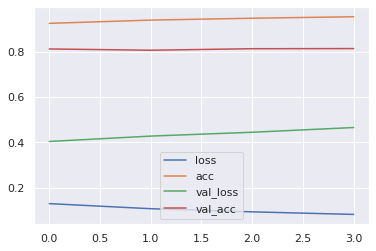

In [ ]:
losses.plot()

In [ ]:
print(m6.metrics_names)
print(m6.evaluate(X_test,Y_test,verbose=0))

['loss', 'acc']
[0.4592786133289337, 0.8153204321861267]


In [51]:


from keras.layers import SimpleRNN
model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=125, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.4))
model.add(SimpleRNN(MAX_SEQUENCE_LENGTH, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 125)          60125     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 125)           0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 125)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               22600     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 563,028
Trainable params: 563,028
Non-trainable params: 0
________________________________________________

In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)

In [ ]:
model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,validation_data=(X_val, Y_val), shuffle = True, callbacks = [early_stopping,model_checkpoint], verbose = 0)



INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


In [ ]:
losses = pd.DataFrame(model.history.history)
print(losses)

        loss  accuracy  val_loss  val_accuracy
0   0.668335  0.742589  0.650882      0.767032
1   0.604938  0.771136  0.604136      0.771653
2   0.601496  0.769879  0.611578      0.769718
3   0.576020  0.779549  0.601291      0.771737
4   0.549069  0.790915  0.586602      0.781582
5   0.537082  0.796847  0.596862      0.771549
6   0.529864  0.799122  0.593858      0.777107
7   0.516362  0.803386  0.588492      0.778502
8   0.507152  0.805608  0.580712      0.779834
9   0.500406  0.809854  0.585109      0.781437
10  0.491439  0.813717  0.581896      0.786849
11  0.486866  0.815484  0.595694      0.778065
12  0.481541  0.818160  0.592971      0.783997


In [ ]:
print(model.metrics_names)
print(model.evaluate(X_test,Y_test,verbose=0))

['loss', 'accuracy']
[0.5930810570716858, 0.7831534743309021]


In [ ]:


from keras.layers import SimpleRNN
from keras.layers import GRU,LSTM


model = Sequential()
model.add(Embedding(nb_words,EMBEDDING_DIM,input_length=MAX_SEQUENCE_LENGTH))
model.add(LSTM(125, dropout=0.2,recurrent_dropout=0.2,activation='relu',return_sequences=True))
model.add(MaxPooling1D(pool_size=2))
model.add(SpatialDropout1D(0.4))
model.add(SimpleRNN(MAX_SEQUENCE_LENGTH, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(3, activation = 'softmax'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 160)          480000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 125)          143000    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 125)           0         
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 50, 125)           0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 100)               22600     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 645,903
Trainable params: 645,903
Non-trainable params: 0
________________________________________________

In [ ]:
training_cycle = 1
batch = 32 
epoch = 40
checkpoint_filepath = '/tmp/checkpoint'

early_stopping = EarlyStopping(patience = 4)
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,save_best_only = True)

In [ ]:
model.fit(X_train, Y_train, batch_size=batch, epochs=epoch,validation_data=(X_val, Y_val), shuffle = True, callbacks = [early_stopping,model_checkpoint], verbose = 0)



INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


In [ ]:
print(model.metrics_names)
print(model.evaluate(X_test,Y_test,verbose=0))

[]
[1.0051172971725464, 0.6570664644241333]


In [ ]:
losses = pd.DataFrame(model.history.history)
print(losses)

Empty DataFrame
Columns: []
Index: []
